In [4]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import mean_squared_error
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정


# pd.read_csv() 함수를 사용해서 데이터를 읽어오는 코드입니다.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [5]:
import numpy as np
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    classification_report,
    mean_squared_error,
    r2_score,
)

def evaluate_model(model, X_valid, y_valid, name="model", verbose=True):
    y_pred = model.predict(X_valid)

    # Log Loss (로스 로스, log_loss)
    loss = None
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_test)
            loss = log_loss(X_valid, y_proba)
        except Exception:
            loss = None

    # R² (결정계수, R-squared)
    r2 = r2_score(y_valid, y_pred)

    # 정확도(Accuracy)
    acc = None
    cls_report = None
    try:
        acc = accuracy_score(y_valid, y_pred)
        cls_report = classification_report(y_valid, y_pred)
    except Exception:
        # 회귀모델(continuous target)일 때는 여기로 옴
        pass

    # MSE / RMSE
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)

    # ------------ 출력 (verbose=True일 때만) ------------
    if verbose:
        print("=" * 40)
        print(f"[{name}] 모델 성능 평가")
        print("=" * 40)

        if loss is not None:
            print("Log Loss:", loss)

        print(f"{name:15s} R score(): {r2:.4f}")

        if acc is not None:
            print("정확도:", acc)
            if cls_report is not None:
                print(cls_report)

        print("-" * 40)
        print(f"MSE (평균 제곱 오차): {mse:.3f}")
        print(f"RMSE (평균 제곱근 오차): {rmse:.3f}")
        print(f"R² Score (결정계수): {r2:.3f}")
        print("=" * 40)

    # 핵심: 정확도(없으면 None)를 리턴
    return acc

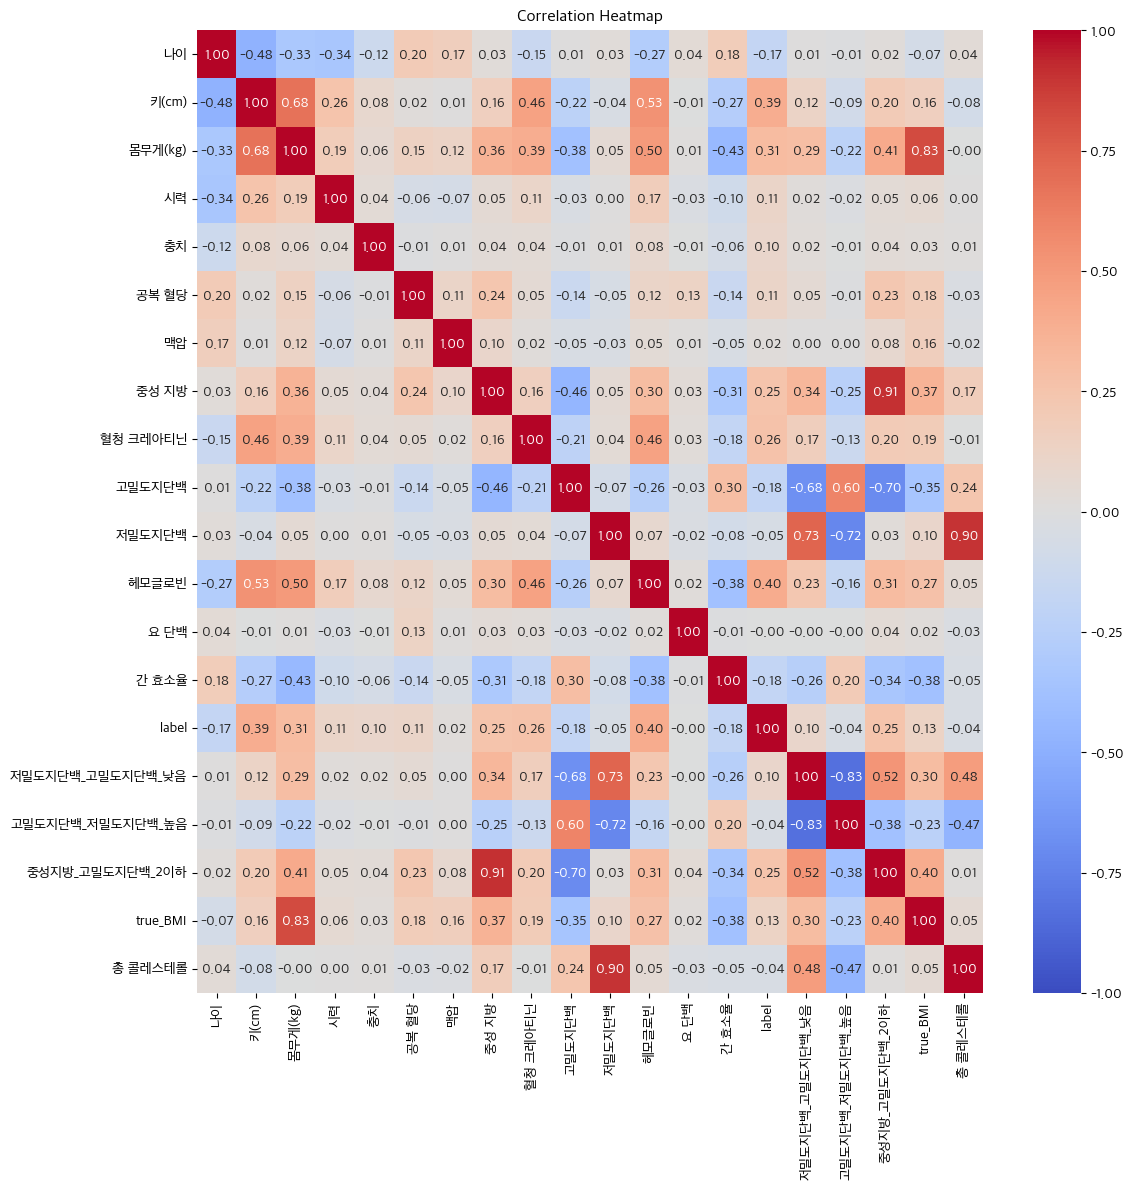

In [146]:
corr = train.corr(numeric_only=True)
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [254]:
train

,ID,나이,키(cm),몸무게(kg),시력,충치,공복 혈당,맥압,중성 지방,혈청 크레아티닌,...,헤모글로빈,요 단백,간 효소율,label,저밀도지단백_고밀도지단백_낮음,고밀도지단백_저밀도지단백_높음,중성지방_고밀도지단백_2이하,true_BMI,총 콜레스테롤,키(m)
0,TRAIN_0000,35,170,70,1.10,1,98,40,80,1.3,...,15.9,1,1.53,1,1.600000,0.625000,1.066667,24.221453,211.0,1.70
1,TRAIN_0001,40,150,55,1.00,0,173,39,104,0.6,...,11.8,1,1.45,0,3.260870,0.306667,2.260870,24.444444,216.8,1.50
2,TRAIN_0002,60,170,50,0.75,0,96,40,61,0.8,...,15.3,1,1.04,0,2.069767,0.483146,1.418605,17.301038,144.2,1.70
3,TRAIN_0003,40,150,45,0.50,0,92,40,46,0.7,...,13.4,1,1.18,0,1.666667,0.600000,0.696970,20.000000,185.2,1.50
4,TRAIN_0004,55,155,65,1.00,0,87,42,95,0.9,...,13.8,1,1.32,0,2.419355,0.413333,1.532258,27.055151,231.0,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,TRAIN_6995,25,170,65,1.50,0,87,45,141,1.2,...,14.9,1,1.50,0,2.545455,0.392857,3.204545,22.491349,184.2,1.70
6996,TRAIN_6996,60,165,65,0.90,0,87,45,82,0.9,...,14.3,1,1.47,1,1.609375,0.621359,1.281250,23.875115,183.4,1.65
6997,TRAIN_6997,40,180,100,1.20,0,97,44,87,0.9,...,15.6,1,1.00,0,1.981481,0.504673,1.611111,30.864198,178.4,1.80
6998,TRAIN_6998,60,150,55,0.60,0,89,57,161,0.6,...,14.4,1,1.00,0,1.551020,0.644737,3.285714,24.444444,157.2,1.50


In [513]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                7000 non-null   object 
 1   나이                7000 non-null   int64  
 2   키(cm)             7000 non-null   int64  
 3   몸무게(kg)           7000 non-null   int64  
 4   시력                7000 non-null   float64
 5   충치                7000 non-null   int64  
 6   공복 혈당             7000 non-null   int64  
 7   맥압                7000 non-null   int64  
 8   중성 지방             7000 non-null   int64  
 9   혈청 크레아티닌          7000 non-null   float64
 10  고밀도지단백            7000 non-null   int64  
 11  저밀도지단백            7000 non-null   int64  
 12  헤모글로빈             7000 non-null   float64
 13  요 단백              7000 non-null   int64  
 14  간 효소율             7000 non-null   float64
 15  label             7000 non-null   int64  
 16  저밀도지단백_고밀도지단백_낮음  7000 non-null   float64


In [2]:
train.rename(columns={'혈압': '맥압'}, inplace=True)
test.rename(columns={'혈압': '맥압'}, inplace=True)

In [3]:
train.loc[train['시력'] > 2, '시력'] = 2.0
train.loc[train['혈청 크레아티닌'] > 1.5, '혈청 크레아티닌'] = 1.5
train.loc[train['요 단백'] > 4, '요 단백'] = 4.0
train.loc[train['저밀도지단백'] > 150, '저밀도지단백'] = 150
train.loc[train['고밀도지단백'] > 100, '고밀도지단백'] = 100
train.loc[train['중성 지방'] > 200, '중성 지방'] = 200
train.loc[train['공복 혈당'] > 200, '공복 혈당'] = 200

train.loc[train['저밀도지단백'] < 22, '저밀도지단백'] = 22
train.loc[train['고밀도지단백'] < 22, '고밀도지단백'] = 22


In [4]:
test.loc[test['시력'] > 2, '시력'] = 2.0
test.loc[test['혈청 크레아티닌'] > 1.5, '혈청 크레아티닌'] = 1.5
test.loc[test['요 단백'] > 4, '요 단백'] = 4.0
test.loc[test['저밀도지단백'] > 150, '저밀도지단백'] = 150
test.loc[test['고밀도지단백'] > 100, '고밀도지단백'] = 100
test.loc[test['중성 지방'] > 200, '중성 지방'] = 200
test.loc[test['공복 혈당'] > 200, '공복 혈당'] = 200
test.loc[test['간 효소율'] > 10, '간 효소율'] = 10

test.loc[test['저밀도지단백'] < 22, '저밀도지단백'] = 22
test.loc[test['고밀도지단백'] < 22, '고밀도지단백'] = 22


In [5]:
train['저밀도지단백_고밀도지단백_낮음'] = train['저밀도지단백'] / train['고밀도지단백']
train['고밀도지단백_저밀도지단백_높음'] = train['고밀도지단백'] / train['저밀도지단백']
train['중성지방_고밀도지단백_2이하'] = train['중성 지방'] / train['고밀도지단백']
train['true_BMI'] = train['몸무게(kg)'] / ((train['키(cm)'] / 100) ** 2)
train['총 콜레스테롤'] = train['저밀도지단백'] +train['고밀도지단백'] + (train['중성 지방'] / 5)
train['나이_BMI'] = train['나이'] * train['true_BMI']
train['키(m)'] = train['키(cm)'] * 0.01
train['고밀도지단백-저밀도지단백'] = train['고밀도지단백'] - train['저밀도지단백']
train['나이/간 효소율'] = train['나이'] / train['간 효소율']
train['헤모글로빈*나이'] = train['헤모글로빈'] * train['나이']

In [6]:
test['저밀도지단백_고밀도지단백_낮음'] = test['저밀도지단백'] / test['고밀도지단백']
test['고밀도지단백_저밀도지단백_높음'] = test['고밀도지단백'] / test['저밀도지단백']
test['중성지방_고밀도지단백_2이하'] = test['중성 지방'] / test['고밀도지단백']
test['true_BMI'] = test['몸무게(kg)'] / ((test['키(cm)'] / 100) ** 2)
test['총 콜레스테롤'] = test['저밀도지단백'] +test['고밀도지단백'] + (test['중성 지방'] / 5)
test['나이_BMI'] = test['나이'] * test['true_BMI']
test['키(m)'] = test['키(cm)'] * 0.01
test['고밀도지단백-저밀도지단백'] = test['고밀도지단백'] - test['저밀도지단백']
test['나이/간 효소율'] = test['나이'] / test['간 효소율']
test['헤모글로빈*나이'] = test['헤모글로빈'] * test['나이']

In [7]:
train.drop(columns=['BMI','콜레스테롤'], inplace=True)

In [8]:
test.drop(columns=['BMI','콜레스테롤'], inplace=True)

In [9]:
X = train.drop(['label','ID',], axis = 1)
y = train['label']
X_test = test.drop(['ID',], axis = 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


---

# 모델링

In [6]:
# 선형 모델 (Linear Models)
from sklearn.linear_model import LogisticRegression  # 로지스틱 회귀

# 거리 기반 (Distance-based)
from sklearn.neighbors import KNeighborsClassifier   # k-최근접 이웃

# 트리 기반 (Tree-based)
from sklearn.tree import DecisionTreeClassifier      # 결정나무
from sklearn.ensemble import RandomForestClassifier  # 랜덤 포레스트
from sklearn.ensemble import GradientBoostingClassifier  # 그래디언트 부스팅

# 서포트 벡터 머신 (SVM)
from sklearn.svm import SVC                          # 서포트 벡터 분류
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False


In [13]:
models = [
    ('LogisticRegression',LogisticRegression(max_iter=1000, random_state=42)),
    ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=42)),
    ('RandomForestClassifier',RandomForestClassifier(n_estimators=100, random_state=42)),
    ('GradientBoostingClassifier',GradientBoostingClassifier(random_state=42)),
    ('SVC',SVC(probability=True, random_state=42)),
    ('GradientBoostingClassifier',GradientBoostingClassifier(random_state=42)),
    ('XGBClassifier',XGBClassifier(random_state=42)),
]

results = []

for name,base_model in models:
    model = clone(base_model)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    cv_scores = cross_val_score(
        base_model, X, y, cv=5, scoring='accuracy'
        )
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        "name": name,
        "train_acc": train_acc,
        "valid_acc": valid_acc,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
    })

    results_sorted = sorted(results, key=lambda x: x["valid_acc"], reverse=True)

for r in results_sorted:
    gap = r["train_acc"] - r["valid_acc"]
    print(
                f"{r['name']}\n"
        f"  Train Acc: {r['train_acc']}\n"
        f"  Valid Acc: {r['valid_acc']}\n"
        f"  Gap(Train-Valid): {gap}\n"
        f"  CV Mean: {r['cv_mean']} (+/- {r['cv_std']})\n"
    )


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

RandomForestClassifier
  Train Acc: 1.0
  Valid Acc: 0.7407142857142858
  Gap(Train-Valid): 0.25928571428571423
  CV Mean: 0.7401428571428571 (+/- 0.006989788470128617)

XGBClassifier
  Train Acc: 0.9826785714285714
  Valid Acc: 0.7321428571428571
  Gap(Train-Valid): 0.2505357142857143
  CV Mean: 0.7192857142857143 (+/- 0.010468611977463568)

GradientBoostingClassifier
  Train Acc: 0.7716071428571428
  Valid Acc: 0.7285714285714285
  Gap(Train-Valid): 0.04303571428571429
  CV Mean: 0.724 (+/- 0.002806697529198338)

GradientBoostingClassifier
  Train Acc: 0.7716071428571428
  Valid Acc: 0.7285714285714285
  Gap(Train-Valid): 0.04303571428571429
  CV Mean: 0.724 (+/- 0.002806697529198338)

LogisticRegression
  Train Acc: 0.7075
  Valid Acc: 0.7207142857142858
  Gap(Train-Valid): -0.013214285714285734
  CV Mean: 0.7070000000000001 (+/- 0.010295630140987024)

SVC
  Train Acc: 0.69875
  Valid Acc: 0.7135714285714285
  Gap(Train-Valid): -0.014821428571428541
  CV Mean: 0.7001428571428571 (+/

---

# 1차 성능 평가

```python
RandomForestClassifier
  Train Acc: 1.0
  Valid Acc: 0.745
  Gap(Train-Valid): 0.255
  CV Mean: 0.7312857142857143 (+/- 0.008273389848897288)

GradientBoostingClassifier
  Train Acc: 0.77375
  Valid Acc: 0.7364285714285714
  Gap(Train-Valid): 0.037321428571428616
  CV Mean: 0.7282857142857143 (+/- 0.005707138387268055)

GradientBoostingClassifier
  Train Acc: 0.77375
  Valid Acc: 0.7364285714285714
  Gap(Train-Valid): 0.037321428571428616
  CV Mean: 0.7282857142857143 (+/- 0.005707138387268055)

XGBClassifier
  Train Acc: 0.9864285714285714
  Valid Acc: 0.7192857142857143
  Gap(Train-Valid): 0.2671428571428571
  CV Mean: 0.726 (+/- 0.005795846507171663)

SVC
  Train Acc: 0.6992857142857143
  Valid Acc: 0.7157142857142857
  Gap(Train-Valid): -0.01642857142857146
  CV Mean: 0.7009999999999998 (+/- 0.014530755559944491)

LogisticRegression
  Train Acc: 0.7067857142857142
  Valid Acc: 0.715
  Gap(Train-Valid): -0.00821428571428573
  CV Mean: 0.7064285714285714 (+/- 0.00769309258162075)

DecisionTreeClassifier
  Train Acc: 1.0
  Valid Acc: 0.665
  Gap(Train-Valid): 0.33499999999999996
  CV Mean: 0.6777142857142857 (+/- 0.007946247991527669)

```

---

# 2차 성능 평가 전처리x

In [7]:
train.rename(columns={'혈압': '맥압'}, inplace=True)
test.rename(columns={'혈압': '맥압'}, inplace=True)

train.loc[train['시력'] > 2, '시력'] = 2.0
train.loc[train['혈청 크레아티닌'] > 1.5, '혈청 크레아티닌'] = 1.5
train.loc[train['요 단백'] > 4, '요 단백'] = 4.0
train.loc[train['저밀도지단백'] > 150, '저밀도지단백'] = 150
train.loc[train['고밀도지단백'] > 100, '고밀도지단백'] = 100
train.loc[train['중성 지방'] > 200, '중성 지방'] = 200
train.loc[train['공복 혈당'] > 200, '공복 혈당'] = 200

train.loc[train['저밀도지단백'] < 22, '저밀도지단백'] = 22
train.loc[train['고밀도지단백'] < 22, '고밀도지단백'] = 22


In [8]:
test.loc[test['시력'] > 2, '시력'] = 2.0
test.loc[test['혈청 크레아티닌'] > 1.5, '혈청 크레아티닌'] = 1.5
test.loc[test['요 단백'] > 4, '요 단백'] = 4.0
test.loc[test['저밀도지단백'] > 150, '저밀도지단백'] = 150
test.loc[test['고밀도지단백'] > 100, '고밀도지단백'] = 100
test.loc[test['중성 지방'] > 200, '중성 지방'] = 200
test.loc[test['공복 혈당'] > 200, '공복 혈당'] = 200
test.loc[test['간 효소율'] > 10, '간 효소율'] = 10

test.loc[test['저밀도지단백'] < 22, '저밀도지단백'] = 22
test.loc[test['고밀도지단백'] < 22, '고밀도지단백'] = 22


#대사 계열
train['저밀도지단백_고밀도지단백_낮음'] = train['저밀도지단백'] / train['고밀도지단백']
train['고밀도지단백_저밀도지단백_높음'] = train['고밀도지단백'] / train['저밀도지단백']
train['고밀도지단백-저밀도지단백'] = train['고밀도지단백'] - train['저밀도지단백']
train['중성지방_고밀도지단백_2이하'] = train['중성 지방'] / train['고밀도지단백']
train['총 콜레스테롤'] = train['저밀도지단백'] +train['고밀도지단백'] + (train['중성 지방'] / 5)
train['true_BMI'] = train['몸무게(kg)'] / ((train['키(cm)'] / 100) ** 2)
train['나이/간 효소율'] = train['나이'] / train['간 효소율']





#구간별
train["age_bin"] = (train["나이"] // 10) * 10
train['BMI_bin'] = (train['BMI']// 10) * 10
train['나이_BMI'] = train['나이'] * train['true_BMI']
train['키(m)'] = train['키(cm)'] * 0.01


#혈압계열
train['맥압/나이'] = train['맥압'] / train['나이']
train['헤모글로빈_키구간'] = train['키(m)'] * train['헤모글로빈']
train['헤모글로빈*나이'] = train['헤모글로빈'] * train['나이']
train["헤모글로빈_나이구간"] = train["age_bin"] * train['헤모글로빈']
train['헤마토크릿'] = train['헤모글로빈'] * 3



test['저밀도지단백_고밀도지단백_낮음'] = test['저밀도지단백'] / test['고밀도지단백']
test['고밀도지단백_저밀도지단백_높음'] = test['고밀도지단백'] / test['저밀도지단백']
test['중성지방_고밀도지단백_2이하'] = test['중성 지방'] / test['고밀도지단백']
test['true_BMI'] = test['몸무게(kg)'] / ((test['키(cm)'] / 100) ** 2)
test['총 콜레스테롤'] = test['저밀도지단백'] +test['고밀도지단백'] + (test['중성 지방'] / 5)
test['나이_BMI'] = test['나이'] * test['true_BMI']
test['키(m)'] = test['키(cm)'] * 0.01
test['고밀도지단백-저밀도지단백'] = test['고밀도지단백'] - test['저밀도지단백']
test['나이/간 효소율'] = test['나이'] / test['간 효소율']
test['헤모글로빈*나이'] = test['헤모글로빈'] * test['나이']
test["age_bin"] = (test["나이"] // 10) * 10
test['BMI_bin'] = (test['BMI']// 10) * 10
test['맥압/나이'] = test['맥압'] / test['나이']
test['헤모글로빈_키구간'] = test['키(m)'] * test['헤모글로빈']
test["헤모글로빈_나이구간"] = test["age_bin"] * test['헤모글로빈']
test['헤마토크릿'] = test['헤모글로빈'] * 3

cols = [
        "나이",
        "키(cm)",
        "몸무게(kg)",
        "시력",
        "충치",
        "공복 혈당",
        "맥압",
        "중성 지방",
        "혈청 크레아티닌",
        #"고밀도지단백",
        "저밀도지단백",
        "헤모글로빈",
        "요 단백",
        #"간 효소율",
        #"저밀도지단백_고밀도지단백_낮음",
        #"고밀도지단백_저밀도지단백_높음",
        "중성지방_고밀도지단백_2이하",
        "true_BMI",
        "총 콜레스테롤",
        "나이_BMI",
        "키(m)",
        "고밀도지단백-저밀도지단백",
        "나이/간 효소율",
        "헤모글로빈*나이",
        '콜레스테롤',
        #'BMI',
        'age_bin',
        'BMI_bin',
        '맥압/나이',
        '헤모글로빈_키구간',
        '헤모글로빈_나이구간',
        #'헤마토크릿',
        #'평균적혈구혈색농도'
        ]

X = train[cols]
y = train['label']
X_test = test[cols]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [9]:
models = [
    ('LogisticRegression',LogisticRegression(max_iter=1000, random_state=42)),
    ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=42)),
    ('RandomForestClassifier',RandomForestClassifier(n_estimators=100, random_state=42)),
    ('GradientBoostingClassifier',GradientBoostingClassifier(random_state=42)),
    ('SVC',SVC(probability=True, random_state=42)),
    ('GradientBoostingClassifier',GradientBoostingClassifier(random_state=42)),
    ('XGBClassifier',XGBClassifier(random_state=42)),
]

results = []

for name,base_model in models:
    model = clone(base_model)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    cv_scores = cross_val_score(
        base_model, X, y, cv=5, scoring='accuracy'
        )
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results.append({
        "name": name,
        "train_acc": train_acc,
        "valid_acc": valid_acc,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
    })

    results_sorted = sorted(results, key=lambda x: x["valid_acc"], reverse=True)

for r in results_sorted:
    gap = r["train_acc"] - r["valid_acc"]
    print(
                f"{r['name']}\n"
        f"  Train Acc: {r['train_acc']}\n"
        f"  Valid Acc: {r['valid_acc']}\n"
        f"  Gap(Train-Valid): {gap}\n"
        f"  CV Mean: {r['cv_mean']} (+/- {r['cv_std']})\n"
    )


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

RandomForestClassifier
  Train Acc: 1.0
  Valid Acc: 0.7542857142857143
  Gap(Train-Valid): 0.24571428571428566
  CV Mean: 0.7394285714285714 (+/- 0.007219587867710431)

GradientBoostingClassifier
  Train Acc: 0.7821428571428571
  Valid Acc: 0.7421428571428571
  Gap(Train-Valid): 0.040000000000000036
  CV Mean: 0.7308571428571429 (+/- 0.011378461572422782)

GradientBoostingClassifier
  Train Acc: 0.7821428571428571
  Valid Acc: 0.7421428571428571
  Gap(Train-Valid): 0.040000000000000036
  CV Mean: 0.7308571428571429 (+/- 0.011378461572422782)

XGBClassifier
  Train Acc: 0.9910714285714286
  Valid Acc: 0.7385714285714285
  Gap(Train-Valid): 0.25250000000000006
  CV Mean: 0.7265714285714286 (+/- 0.009491134423927457)

LogisticRegression
  Train Acc: 0.7080357142857143
  Valid Acc: 0.7214285714285714
  Gap(Train-Valid): -0.013392857142857095
  CV Mean: 0.7124285714285714 (+/- 0.006889803172449989)

SVC
  Train Acc: 0.6983928571428571
  Valid Acc: 0.7028571428571428
  Gap(Train-Valid): -0.

```python
RandomForestClassifier
  Train Acc: 1.0
  Valid Acc: 0.735
  Gap(Train-Valid): 0.265
  CV Mean: 0.7390000000000001 (+/- 0.005952190473142742)

LogisticRegression
  Train Acc: 0.7046428571428571
  Valid Acc: 0.7235714285714285
  Gap(Train-Valid): -0.018928571428571406
  CV Mean: 0.707 (+/- 0.008752842104023082)

GradientBoostingClassifier
  Train Acc: 0.7728571428571429
  Valid Acc: 0.7235714285714285
  Gap(Train-Valid): 0.04928571428571438
  CV Mean: 0.7241428571428572 (+/- 0.007047940790596602)

GradientBoostingClassifier
  Train Acc: 0.7728571428571429
  Valid Acc: 0.7235714285714285
  Gap(Train-Valid): 0.04928571428571438
  CV Mean: 0.7241428571428572 (+/- 0.007047940790596602)

XGBClassifier
  Train Acc: 0.9825
  Valid Acc: 0.7228571428571429
  Gap(Train-Valid): 0.2596428571428572
  CV Mean: 0.7172857142857143 (+/- 0.003539860483818271)

SVC
  Train Acc: 0.695
  Valid Acc: 0.7121428571428572
  Gap(Train-Valid): -0.017142857142857237
  CV Mean: 0.6962857142857143 (+/- 0.011878638003421404)

DecisionTreeClassifier
  Train Acc: 1.0
  Valid Acc: 0.6764285714285714
  Gap(Train-Valid): 0.3235714285714286
  CV Mean: 0.672 (+/- 0.010855262995150225)
```

# 비교 표

| 모델                         | 1차 Train Acc(훈련 정확도) | 1차 Valid Acc(검증 정확도) | 1차 Gap(Train-Valid) | 1차 CV Mean | 2차 Train Acc | 2차 Valid Acc | 2차 Gap(Train-Valid) | 2차 CV Mean |
| -------------------------- | -------------------- | -------------------- | ------------------- | ---------- | ------------ | ------------ | ------------------- | ---------- |
| RandomForestClassifier     | 1.0000               | 0.7450               | 0.2550              | 0.7313     | 1.0000       | 0.7350       | 0.2650              | 0.7390     |
| GradientBoostingClassifier | 0.7738               | 0.7364               | 0.0373              | 0.7283     | 0.7729       | 0.7236       | 0.0493              | 0.7241     |
| XGBClassifier              | 0.9864               | 0.7193               | 0.2671              | 0.7260     | 0.9825       | 0.7229       | 0.2596              | 0.7173     |
| SVC                        | 0.6993               | 0.7157               | -0.0164             | 0.7010     | 0.6950       | 0.7121       | -0.0171             | 0.6963     |
| LogisticRegression         | 0.7068               | 0.7150               | -0.0082             | 0.7064     | 0.7046       | 0.7236       | -0.0189             | 0.7070     |
| DecisionTreeClassifier     | 1.0000               | 0.6650               | 0.3350              | 0.6777     | 1.0000       | 0.6764       | 0.3236              | 0.6720     |


| 모델                           | 1차 Valid | 2차 Valid | 차이(1차−2차)   | 해석                 |
| ---------------------------- | -------- | -------- | ----------- | ------------------ |
| RandomForest (랜덤 포레스트)       | 0.7450   | 0.7350   | **+0.0100** | 파생변수가 약간 도움        |
| GradientBoosting (그래디언트 부스팅) | 0.7364   | 0.7236   | **+0.0129** | 파생변수 덕분에 ~1.3%p 상승 |
| XGB                          | 0.7193   | 0.7229   | **−0.0036** | 거의 비슷, 2차가 약간 우위   |
| SVC                          | 0.7157   | 0.7121   | **+0.0036** | 미세하게 1차가 낫지만 거의 동일 |
| LogisticRegression (로지스틱 회귀) | 0.7150   | 0.7236   | **−0.0086** | 원시데이터 쪽이 더 잘 맞음    |
| DecisionTree (단일 트리)         | 0.6650   | 0.6764   | **−0.0114** | 원시데이터 쪽이 조금 더 나음   |


----


# 그래디언트 부스팅

---

| 모델(Model)                  | Train Acc | Valid Acc | Gap(Train-Valid) | CV Mean | CV Std (±) |
| -------------------------- | --------- | --------- | ---------------- | ------- | ---------- |
| RandomForestClassifier     | 1.0000    | 0.7400    | 0.2600           | 0.7326  | 0.0061     |
| XGBClassifier              | 0.9857    | 0.7321    | 0.2536           | 0.7246  | 0.0068     |
| GradientBoostingClassifier | 0.7770    | 0.7207    | 0.0563           | 0.7261  | 0.0070     |
| LogisticRegression         | 0.7029    | 0.6814    | 0.0214           | 0.6957  | 0.0082     |
| DecisionTreeClassifier     | 1.0000    | 0.6679    | 0.3321           | 0.6764  | 0.0179     |
| SVC                        | 0.6330    | 0.6336    | -0.0005          | 0.6330  | 0.0005     |


# 랜덤포레스트

In [10]:
cols = [
    "나이",
    "키(cm)",
    "몸무게(kg)",
    "시력",
    "충치",
    "공복 혈당",
    "맥압",
    #"중성 지방",
    "혈청 크레아티닌",
    #"고밀도지단백",
    "저밀도지단백",
    "헤모글로빈",
    "요 단백",
    "간 효소율",
    "저밀도지단백_고밀도지단백_낮음",
    "고밀도지단백_저밀도지단백_높음",
    "중성지방_고밀도지단백_2이하",
    #"true_BMI",
    "총 콜레스테롤",
    "나이_BMI",
    #"키(m)",
    "고밀도지단백-저밀도지단백",
    "나이/간 효소율",
   # "헤모글로빈*나이",
]


In [ ]:

X = train[cols]
y = train['label']
X_test = test[cols]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

param_grids = {
        'RandomForestClassifier': {
        'n_estimators': [550],
        'random_state': [42],
        'criterion': ['gini'],
        'max_depth': [20],
        'min_samples_split': [10],
        'min_samples_leaf': [2],
        'class_weight': [
                          {0: 1.0, 1: 1.5},]
    }
}

models = [
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
]

results = []

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import clone


results = []
trained_models = {}  # 나중에 test.csv 예측에 사용할 학습 완료 모델 저장

for name, base_model in models:
    print(f"\n====== {name} ======")

    # (A) GridSearchCV 적용
    if name in param_grids:
        grid = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[name],
            scoring='accuracy',
            cv=2,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)

        print("Best params:", grid.best_params_)
        print("Best CV score (inner):", grid.best_score_)

        model = grid.best_estimator_
        best_params = grid.best_params_
        best_grid_cv_mean = grid.best_score_
    else:
        model = clone(base_model)
        model.fit(X_train, y_train)
        best_params = None
        best_grid_cv_mean = None

    # 학습된 모델 저장 (나중에 test.csv에 사용)
    trained_models[name] = model

    # (B-1) 기본 predict 기준 Train / Valid 성능
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    print("Base Valid Accuracy:", valid_acc)
    print("Classification Report (Base Predict):")
    print(classification_report(y_valid, y_valid_pred))

    # (B-2) Threshold 튜닝 (predict_proba 사용 가능할 때만)
    best_thr = None
    best_thr_acc = None

    if hasattr(model, "predict_proba"):
        probs_valid = model.predict_proba(X_valid)[:, 1]

        thresholds = np.linspace(0.0, 1.0, 101)
        best_thr = 0.5
        best_thr_acc = 0.0

        for thr in thresholds:
            y_pred_thr = (probs_valid >= thr).astype(int)
            acc = accuracy_score(y_valid, y_pred_thr)
            if acc > best_thr_acc:
                best_thr_acc = acc
                best_thr = thr

        print(f"\n[Threshold Tuning] Best Threshold (by Accuracy): {best_thr:.2f}")
        print(f"[Threshold Tuning] Best Accuracy on Valid: {best_thr_acc:.4f}")

        y_best_pred = (probs_valid >= best_thr).astype(int)
        print("Classification Report (Best Threshold):")
        print(classification_report(y_valid, y_best_pred))
    else:
        print("\n[Threshold Tuning] 이 모델은 predict_proba를 지원하지 않아 threshold 튜닝을 생략했습니다.")

    # (C) 전체 데이터에 대한 Cross-Validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std  = cv_scores.std()

    results.append({
        "name": name,
        "train_acc": train_acc,
        "valid_acc": valid_acc,             # 기본 predict 기준
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "best_params": best_params,
        "best_grid_cv_mean": best_grid_cv_mean,
        "best_thr": best_thr,               # threshold 튜닝이 된 모델만 값 존재
        "best_thr_acc": best_thr_acc,       # 튜닝 후 Valid Accuracy
    })

# (D) 정리 출력 (기본 valid_acc 기준 정렬)
results_sorted = sorted(results, key=lambda x: x["valid_acc"], reverse=True)

for r in results_sorted:
    gap = r["train_acc"] - r["valid_acc"]
    print(
        f"\n[Summary] {r['name']}\n"
        f"  Train Acc: {r['train_acc']:.4f}\n"
        f"  Valid Acc (Base Predict): {r['valid_acc']:.4f}\n"
        f"  Gap(Train-Valid): {gap:.4f}\n"
        f"  CV Mean (outer): {r['cv_mean']:.4f} (+/- {r['cv_std']:.4f})\n"
        f"  Grid Best CV Mean (inner): {r['best_grid_cv_mean']}\n"
        f"  Best Threshold (if tuned): {r['best_thr']}\n"
        f"  Best Threshold Acc: {r['best_thr_acc']}\n"
        f"  Best Params: {r['best_params']}\n"
    )



====== RandomForestClassifier ======
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best params: {'class_weight': {0: 1.0, 1: 1.5}, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 550, 'random_state': 42}
Best CV score (inner): 0.7310714285714286
Base Valid Accuracy: 0.7528571428571429
Classification Report (Base Predict):
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       886
           1       0.64      0.74      0.69       514

    accuracy                           0.75      1400
   macro avg       0.74      0.75      0.74      1400
weighted avg       0.76      0.75      0.76      1400


[Threshold Tuning] Best Threshold (by Accuracy): 0.53
[Threshold Tuning] Best Accuracy on Valid: 0.7571
Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       886
           1       0.66    

Exception ignored in: <function ResourceTracker.__del__ at 0x105496160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10729a160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1047da160>
Traceback (most recent call last

---
# 예측

In [630]:
import pandas as pd

# 1) 가장 좋은 모델 선택 (best_thr_acc 기준으로 선택)
best_result = max(
    results,
    key=lambda r: r["best_thr_acc"] if r["best_thr_acc"] is not None else -1
)

best_name = best_result["name"]
best_thr = best_result["best_thr"]

print("Best model by threshold-tuned accuracy:", best_name)
print("Best threshold:", best_thr)

best_model = trained_models[best_name]



X_test_final = X_test

# 3) test.csv에 대한 확률 예측 및 최적 threshold 적용
test_probs = best_model.predict_proba(X_test_final)[:, 1]
test_pred = (test_probs >= best_thr).astype(int)

# 4) 제출 파일(submission) 생성
#   - id 컬럼 이름은 실제 test.csv에 맞게 수정 필요 (예: 'id', 'PatientID' 등)
submission = pd.DataFrame({         # test.csv에 있는 식별자 컬럼 이름으로 변경
    "target": test_pred           # 제출할 타깃 이름에 맞춰 변경 (예: 'Outcome')
})

submission.to_csv("submission.csv", index=False)
print("submission.csv saved.")


Best model by threshold-tuned accuracy: RandomForestClassifier
Best threshold: 0.46
submission.csv saved.


In [ ]:
submission.head(15)

,ID,label
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,0
5,TEST_0005,1
6,TEST_0006,0
7,TEST_0007,0
8,TEST_0008,1
9,TEST_0009,0
